In [402]:
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection, metrics, linear_model, decomposition, cross_decomposition, datasets
from itertools import combinations
import numpy as np
import time 

8. In this exercise, we will generate simulated data, and will then use this data to perform best subset selection.


(a) Use the rnorm() function to generate a predictor X of length n = 100, as well as a noise vector ε of length n = 100.

In [167]:
x = np.random.normal(0,1, 100)
eps = np.random.normal(0,1, 100)

(b) Generate a response vector Y of length n = 100 according to the model
Y = β0 +β1X +β2X2 +β3X3 +ε, where β0, β1, β2, and β3 are constants of your choice.

In [168]:
coeffs = np.array([1,2,3,4])
design_matrix = pd.DataFrame({ 'c' : np.repeat(1, 100),
                              'x' : x, \
                              'x2' : x ** 2, \
                              'x3' : x ** 3})
y = (design_matrix @ coeffs.reshape(-1, 1)) + eps.reshape(-1, 1)

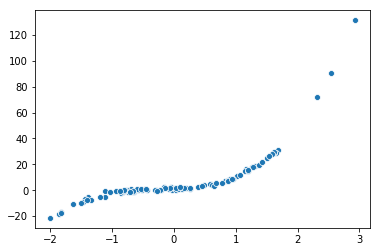

In [177]:
sns.scatterplot(x=x, y=y.T.values[0])

(c) Use the regsubsets() function to perform best subset selection in order to choose the best model containing the predictors X, X2, . . . , X10. What is the best model obtained according to Cp, BIC, and adjusted R2? Show some plots to provide evidence for your answer, and report the coefficients of the best model ob- tained. Note you will need to use the data.frame() function to create a single data set containing both X and Y .

In [418]:
def n_choose_k(n, k):
    return int(np.math.factorial(n) / (np.math.factorial(n - k) * np.math.factorial(k)))

def best_subset(n_predictors, target_column, data):
    i = 1
    predictors = data.drop(target_column, axis=1).columns
    top_models = []
    while i <= n_predictors:
        tick = time.time()
        cmbs = list(combinations(predictors, i))
        formulae = ['{} ~ '.format(target_column) + ' + '.join(s) for s in cmbs]
        models = [smf.ols(formula=f, data=data).fit() for f in formulae]
        top_model = sorted(models, key=lambda m: m.rsquared, reverse=True)[0]
        top_models.append(top_model)
        tock = time.time()
        print('{}/{} : {} combinations, {} seconds'.format(i, n_predictors, n_choose_k(n_predictors, i), tock-tick))
        i += 1
    return pd.DataFrame({'model' : top_models, 'n_predictors' : range(1, n_predictors + 1)})

In [198]:
data = pd.DataFrame({'x' : x, \
                     'x2' : x ** 2,\
                     'x3' : x ** 3,\
                     'x4' : x ** 4,\
                     'x5' : x ** 5,\
                     'x6' : x ** 6,\
                     'x7' : x ** 7,\
                     'x8' : x ** 8,\
                     'x9' : x ** 9,\
                     'x10' : x ** 10,\
                     'y' : y.T.values[0]})

# 2 ^ 10 = 1024 possible subsets
best = best_subset(10, 'y', data)

1/10 : 10 combinations, 0.03826308250427246 seconds
2/10 : 45 combinations, 0.18390679359436035 seconds
3/10 : 120 combinations, 0.6283471584320068 seconds
4/10 : 210 combinations, 1.3881821632385254 seconds
5/10 : 252 combinations, 1.7857210636138916 seconds
6/10 : 210 combinations, 1.7825541496276855 seconds
7/10 : 120 combinations, 1.0421671867370605 seconds
8/10 : 45 combinations, 0.45599985122680664 seconds
9/10 : 10 combinations, 0.1031639575958252 seconds
10/10 : 1 combinations, 0.01294708251953125 seconds


In [180]:
# Select between models with different numbers of predictors using adjusted training metrics
best['adj_R_sq'] = best['model'].map(lambda m: m.rsquared_adj)
best['bic'] = best['model'].map(lambda m: m.bic)
best['aic'] = best['model'].map(lambda m: m.aic)

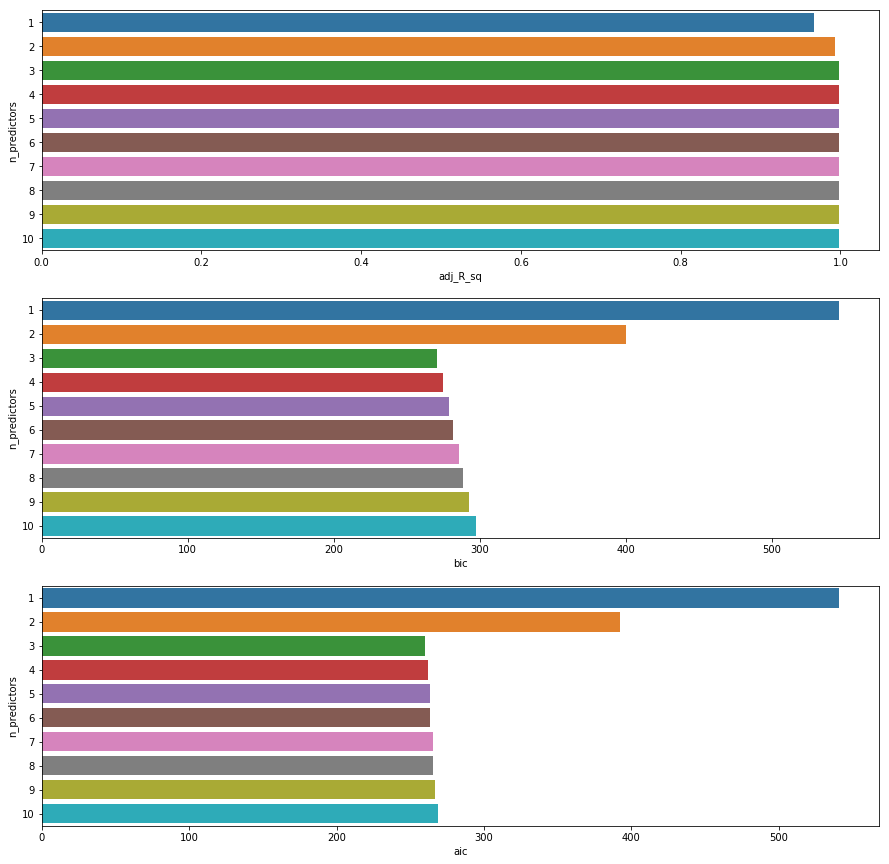

In [181]:
# Plot the error metrics
_, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(15,15))
sns.barplot(y='n_predictors', x='adj_R_sq', data=best, ax=ax1, orient='h')
sns.barplot(y='n_predictors', x='bic', data=best, ax=ax2, orient='h')
sns.barplot(y='n_predictors', x='aic', data=best, ax=ax3, orient='h')

In [182]:
print(best.sort_values('adj_R_sq', ascending=False)['model'].iloc[0].summary())
print(best.sort_values('bic', ascending=True)['model'].iloc[0].summary())
print(best.sort_values('aic', ascending=True)['model'].iloc[0].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 1.680e+04
Date:                Mon, 01 Oct 2018   Prob (F-statistic):          1.93e-130
Time:                        11:28:39   Log-Likelihood:                -126.13
No. Observations:                 100   AIC:                             260.3
Df Residuals:                      96   BIC:                             270.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.0229      0.117      8.713      0.0

(d) Repeat (c), using forward stepwise selection and also using backwards stepwise selection. How does your answer compare to the results in (c)?

In [236]:
# Forward selection:
# There are 1 + 10(1 + 10) / 2 = 56 possible models in this space 

def fwd_selection(target_column, data):
    predictors = data.drop('y', axis=1).columns
    formulae_s1 = [(p, 'y ~ {}'.format(p)) for p in predictors]
    models_s1 = [(p, smf.ols(formula=f, data=data).fit()) for p, f in formulae_s1]
    predictor_s1, model_s1 = sorted(models_s1, key=lambda tup: tup[1].rsquared, reverse=True)[0]
    predictors = predictors.drop(predictor_s1)
    formula = 'y ~ {}'.format(predictor_s1)
    step_models = [model_s1]
    while len(predictors) > 0:
        models = []
        for p in predictors:
            f = formula + ' + ' + p
            m = smf.ols(formula=f, data=data).fit()
            models.append((p, m))
                    
        predictor, model = sorted(models, key=lambda tup: tup[1].rsquared, reverse=True)[0]
        step_models.append(model)
        formula = formula + ' + ' + predictor
        predictors = predictors.drop(predictor)
        
    return pd.DataFrame({'model': step_models, 'n_predictors' : range(1,data.shape[1])})

In [184]:
# Select between models with different numbers of predictors using adjusted training metrics
best = fwd_selection('y', data)
best['adj_R_sq'] = best['model'].map(lambda m: m.rsquared_adj)
best['bic'] = best['model'].map(lambda m: m.bic)
best['aic'] = best['model'].map(lambda m: m.aic)

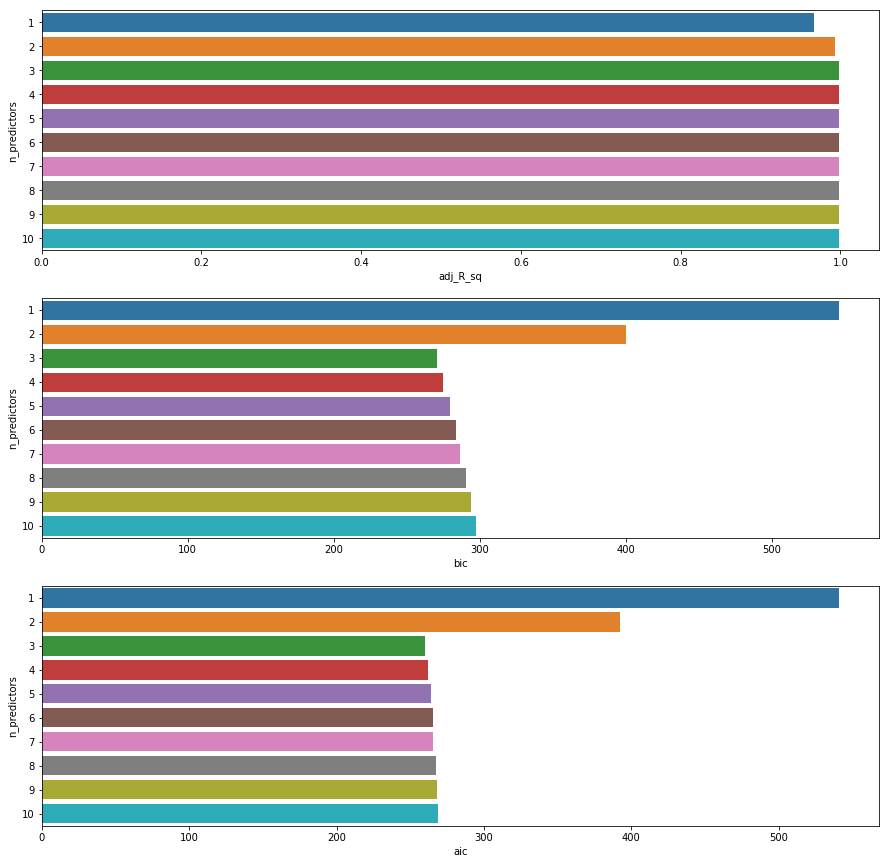

In [185]:
# Plot the error metrics
_, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(15,15))
sns.barplot(y='n_predictors', x='adj_R_sq', data=best, ax=ax1, orient='h')
sns.barplot(y='n_predictors', x='bic', data=best, ax=ax2, orient='h')
sns.barplot(y='n_predictors', x='aic', data=best, ax=ax3, orient='h')

In [186]:
print(best.sort_values('adj_R_sq', ascending=False)['model'].iloc[0].summary())
print(best.sort_values('bic', ascending=True)['model'].iloc[0].summary())
print(best.sort_values('aic', ascending=True)['model'].iloc[0].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 1.680e+04
Date:                Mon, 01 Oct 2018   Prob (F-statistic):          1.93e-130
Time:                        11:29:24   Log-Likelihood:                -126.13
No. Observations:                 100   AIC:                             260.3
Df Residuals:                      96   BIC:                             270.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.0229      0.117      8.713      0.0

In [187]:
# Backward selection
# There are 1 + p(1 + p) / 2 possible models in this space 

def bwd_selection(target_column, data):
    predictors = data.drop('y', axis=1).columns
    formula_s1 = 'y ~ ' + ' + '.join(predictors)
    model_s1 = smf.ols(formula=formula_s1, data=data).fit()
    step_models = [model_s1]
    while len(predictors) > 1:
        models = []
        for p in predictors:
            f = 'y ~ ' + ' + '.join(predictors.drop(p))
            m = smf.ols(formula=f, data=data).fit()
            models.append((p, m))
        p, m = sorted(models, key=lambda tup: tup[1].rsquared, reverse=True)[0]
        step_models.append(m)
        predictors = predictors.drop(p)
    return pd.DataFrame({'model': step_models, 'n_predictors' : range(1, 11)[::-1]})

In [188]:
# Select between models with different numbers of predictors using adjusted training metrics
best = bwd_selection('y', data)
best['adj_R_sq'] = best['model'].map(lambda m: m.rsquared_adj)
best['bic'] = best['model'].map(lambda m: m.bic)
best['aic'] = best['model'].map(lambda m: m.aic)

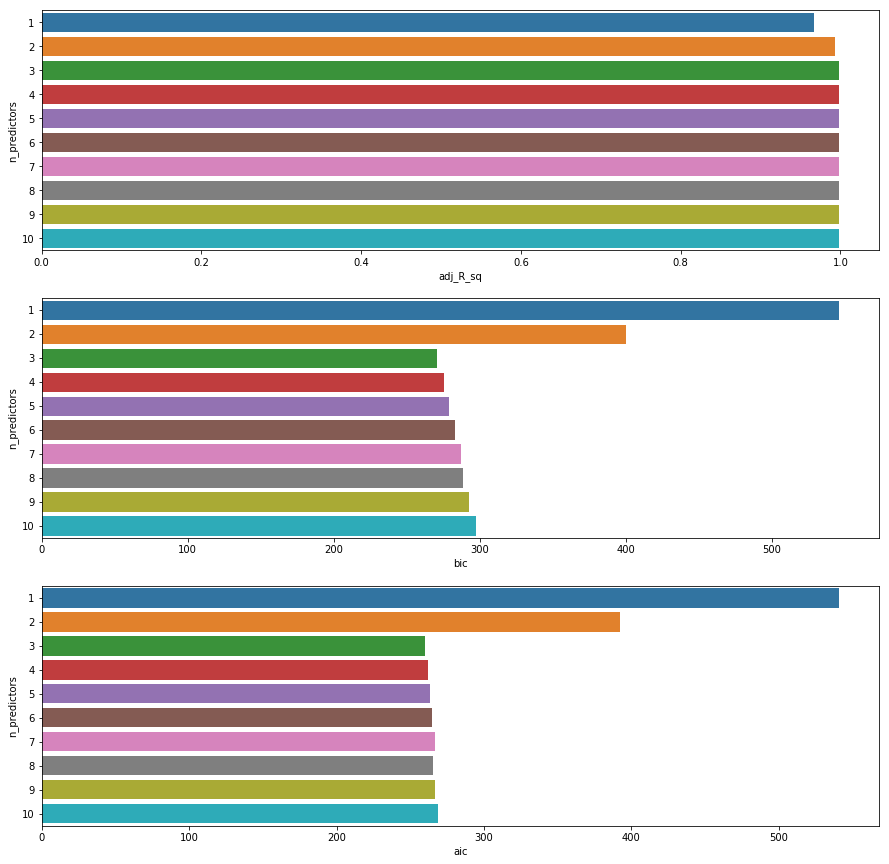

In [189]:
# Plot the error metrics
_, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(15,15))
sns.barplot(y='n_predictors', x='adj_R_sq', data=best, ax=ax1, orient='h')
sns.barplot(y='n_predictors', x='bic', data=best, ax=ax2, orient='h')
sns.barplot(y='n_predictors', x='aic', data=best, ax=ax3, orient='h')

In [190]:
print(best.sort_values('adj_R_sq', ascending=False)['model'].iloc[0].summary())
print(best.sort_values('bic', ascending=True)['model'].iloc[0].summary())
print(best.sort_values('aic', ascending=True)['model'].iloc[0].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 1.680e+04
Date:                Mon, 01 Oct 2018   Prob (F-statistic):          1.93e-130
Time:                        11:29:50   Log-Likelihood:                -126.13
No. Observations:                 100   AIC:                             260.3
Df Residuals:                      96   BIC:                             270.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.0229      0.117      8.713      0.0

(e) Now fit a lasso model to the simulated data, again using X,X2, . . . , X 10 as predictors. Use cross-validation to select the optimal value of λ. Create plots of the cross-validation error as a function of λ. Report the resulting coefficient estimates, and discuss the results obtained.

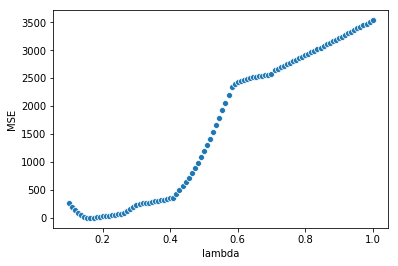

In [192]:
# LASSO Regression - Cross-Validation with test MSE

results = pd.DataFrame()
alpha_range = np.linspace(10**-1, 1, num=100)
for train_idx, test_idx in model_selection.KFold(n_splits=10).split(data):
    train, test = data.iloc[train_idx], data.iloc[test_idx]
    errors = []
    for alpha in alpha_range:
        reg = linear_model.Lasso(alpha=alpha, max_iter=1000000)
        reg.fit(train.drop('y', axis=1), train['y'])
        error = metrics.mean_squared_error(test['y'], reg.predict(test.drop('y', axis=1)))
        errors.append(error)
    results = pd.concat([results, pd.DataFrame(errors, index=alpha_range).T], axis=0, ignore_index=True)
    

df = pd.DataFrame({'lambda' : alpha_range, 'MSE' : results.mean()})
sns.scatterplot(x='lambda', y='MSE', data=df)

In [193]:
reg = linear_model.Lasso(alpha=0.15, max_iter=1000000)
reg.fit(data.drop('y', axis=1), data['y']).coef_
# The cubic term has the largest coefficient
# The 5th order and higher terms have very small coefficeints

array([ 1.78982643e+00,  1.52503944e+00,  4.13617586e+00,  5.68803568e-01,
        1.11648904e-04,  0.00000000e+00,  0.00000000e+00, -1.94037799e-02,
       -1.34039474e-03,  1.99471493e-03])

(f) Now generate a response vector Y according to the model Y = β0 + β7X7 + ε,
and perform best subset selection and the lasso. Discuss the results obtained.

In [197]:
coeffs = np.array([1,2])
eps = np.random.normal(0,1, 100)
x7 = x ** 7
design_matrix = pd.DataFrame({ 'c' : np.repeat(1, 100),
                              'x7' : x7})
y = (design_matrix @ coeffs.reshape(-1, 1)) + eps.reshape(-1, 1)

In [201]:
data['y'] = y
best = best_subset(10, 'y', data)

1/10 : 10 combinations, 0.03963327407836914 seconds
2/10 : 45 combinations, 0.18586397171020508 seconds
3/10 : 120 combinations, 0.7698366641998291 seconds
4/10 : 210 combinations, 1.2466669082641602 seconds
5/10 : 252 combinations, 1.5642271041870117 seconds
6/10 : 210 combinations, 1.5838689804077148 seconds
7/10 : 120 combinations, 1.0425281524658203 seconds
8/10 : 45 combinations, 0.4454309940338135 seconds
9/10 : 10 combinations, 0.11003971099853516 seconds
10/10 : 1 combinations, 0.012729883193969727 seconds


In [202]:
# Select between models with different numbers of predictors using adjusted training metrics
best['adj_R_sq'] = best['model'].map(lambda m: m.rsquared_adj)
best['bic'] = best['model'].map(lambda m: m.bic)
best['aic'] = best['model'].map(lambda m: m.aic)

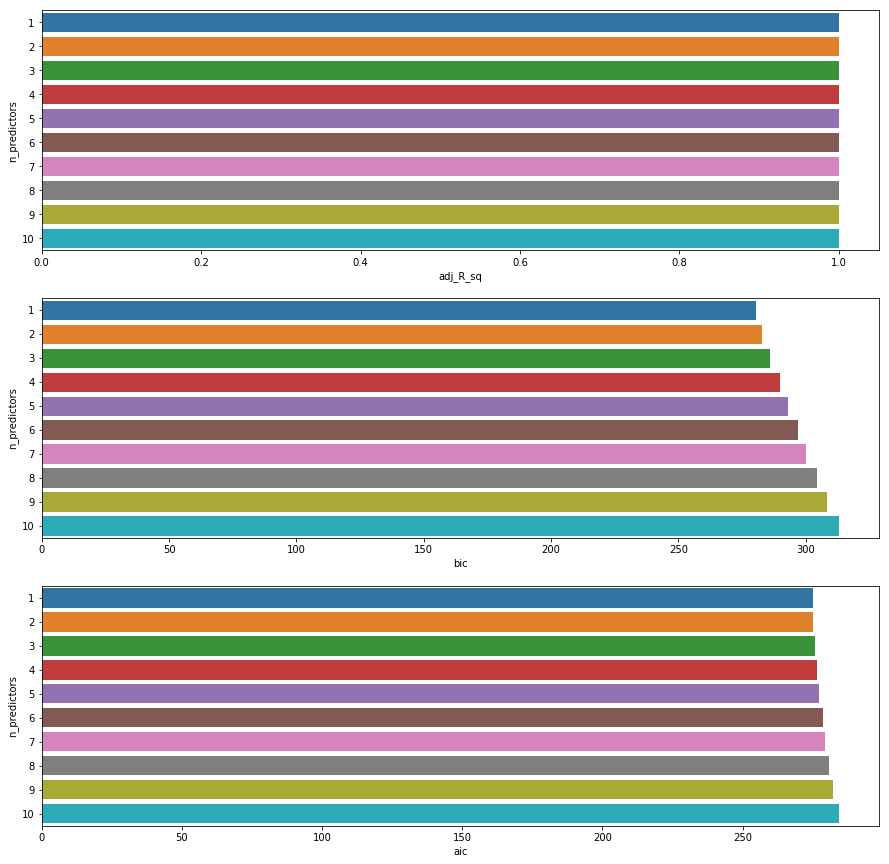

In [203]:
# Plot the error metrics
_, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(15,15))
sns.barplot(y='n_predictors', x='adj_R_sq', data=best, ax=ax1, orient='h')
sns.barplot(y='n_predictors', x='bic', data=best, ax=ax2, orient='h')
sns.barplot(y='n_predictors', x='aic', data=best, ax=ax3, orient='h')

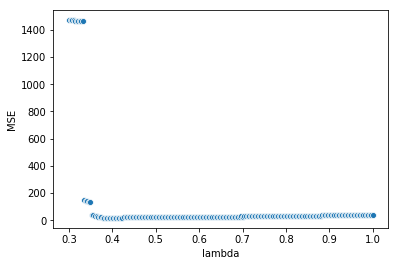

In [210]:
# LASSO Regression - Cross-Validation with test MSE

results = pd.DataFrame()
alpha_range = np.linspace(0.3, 1, num=200)
for train_idx, test_idx in model_selection.KFold(n_splits=10).split(data):
    train, test = data.iloc[train_idx], data.iloc[test_idx]
    errors = []
    for alpha in alpha_range:
        reg = linear_model.Lasso(alpha=alpha, max_iter=1000000)
        reg.fit(train.drop('y', axis=1), train['y'])
        error = np.sqrt(metrics.mean_squared_error(test['y'], reg.predict(test.drop('y', axis=1))))
        errors.append(error)
    results = pd.concat([results, pd.DataFrame(errors, index=alpha_range).T], axis=0, ignore_index=True)
    

df = pd.DataFrame({'lambda' : alpha_range, 'RMSE' : results.mean()})
sns.scatterplot(x='lambda', y='RMSE', data=df)

In [212]:
reg = linear_model.Lasso(alpha=0.5, max_iter=1000000)
reg.fit(data.drop('y', axis=1), data['y']).coef_
# The 7th order term has the largest coefficient
# The first, second and third order terms have zero coeffecients

array([ 0.        , -0.        ,  0.        , -0.62718828,  0.36328617,
        0.60771921,  1.62992381, -0.07840308,  0.07485172, -0.01063306])

9. In this exercise, we will predict the number of applications received using the other variables in the College data set.

In [2]:
college_dat = pd.read_csv('college.csv')
college_dat = college_dat.drop(college_dat.columns[0], axis=1)
college_dat['Private'] = college_dat['Private'].map({'Yes' : 1, 'No' : 0})
college_dat = college_dat.apply(pd.to_numeric, errors='coerce')
college_dat.columns = [c.translate({ord(c):None for c in '.'}) for c in college_dat.columns]
college_dat.head()

,Private,Apps,Accept,Enroll,Top10perc,Top25perc,FUndergrad,PUndergrad,Outstate,RoomBoard,Books,Personal,PhD,Terminal,SFRatio,percalumni,Expend,GradRate
0,1,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
1,1,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
2,1,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
3,1,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
4,1,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15


(a) Split the data set into a training set and a test set.

In [62]:
train, test = model_selection.train_test_split(college_dat, test_size=0.2)

(b) Fit a linear model using least squares on the training set, and
report the test error obtained.

In [63]:
f = 'Apps ~ ' + ' + '.join(train.drop('Apps', axis=1).columns)
model = smf.ols(formula=f, data=train).fit()

test_error_ols = np.sqrt(metrics.mean_squared_error(test['Apps'], model.predict(test)))
print('RMSE: {}'.format(test_error_ols))

RMSE: 1097.8135996785918


(c) Fit a ridge regression model on the training set, with λ chosen
by cross-validation. Report the test error obtained.

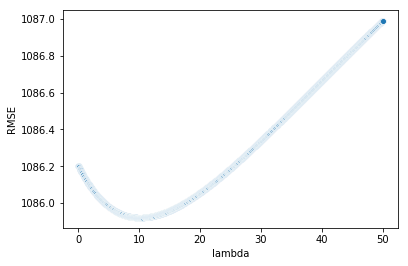

In [64]:
results = pd.DataFrame()
alpha_range = np.linspace(10**-3, 50, num=1000)
for train_idx, test_idx in model_selection.KFold(n_splits=8).split(college_dat):
    train, test = college_dat.iloc[train_idx], college_dat.iloc[test_idx]
    errors = []
    for alpha in alpha_range:
        reg = linear_model.Ridge(alpha=alpha)
        reg.fit(train.drop('Apps', axis=1), train['Apps'])
        error = np.sqrt(metrics.mean_squared_error(test['Apps'], reg.predict(test.drop('Apps', axis=1))))
        errors.append(error)
    results = pd.concat([results, pd.DataFrame(errors, index=alpha_range).T], axis=0, ignore_index=True)

df = pd.DataFrame({'lambda' : alpha_range, 'RMSE' : results.mean()})
sns.scatterplot(x='lambda', y='RMSE', data=df)

In [65]:
test_error_ridge = df.sort_values('RMSE', ascending=True)['RMSE'].iloc[0]
print('RMSE: {}'.format(test_error_ridge))

RMSE: 1085.9207169016076


(d) Fit a lasso model on the training set, with λ chosen by cross-validation. Report the test error obtained, along with the num-
ber of non-zero coefficient estimates.

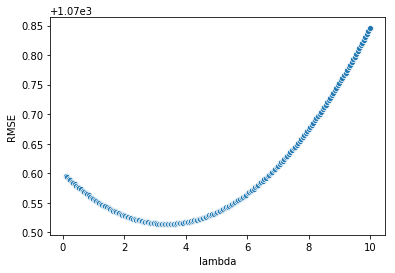

In [66]:
# LASSO Regression - Cross-Validation with test MSE

results = pd.DataFrame()
alpha_range = np.linspace(0.1, 10, num=200)
for train_idx, test_idx in model_selection.KFold(n_splits=12).split(college_dat):
    train, test = college_dat.iloc[train_idx], college_dat.iloc[test_idx]
    errors = []
    for alpha in alpha_range:
        reg = linear_model.Lasso(alpha=alpha, max_iter=1000000)
        reg.fit(train.drop('Apps', axis=1), train['Apps'])
        error = np.sqrt(metrics.mean_squared_error(test['Apps'], reg.predict(test.drop('Apps', axis=1))))
        errors.append(error)
    results = pd.concat([results, pd.DataFrame(errors, index=alpha_range).T], axis=0, ignore_index=True)
    

df = pd.DataFrame({'lambda' : alpha_range, 'RMSE' : results.mean()})
sns.scatterplot(x='lambda', y='RMSE', data=df)

In [67]:
test_error_lasso = df.sort_values('RMSE', ascending=True)['RMSE'].iloc[0]
print('RMSE: {}'.format(test_error_lasso))

RMSE: 1070.514298450505


In [68]:
reg = linear_model.Lasso(alpha=3, max_iter=1000000)
reg.fit(college_dat.drop('Apps', axis=1), college_dat['Apps']).coef_
# there are no zero coefficients

array([-4.53468031e+02,  1.58612352e+00, -8.80863226e-01,  4.97995026e+01,
       -1.41633311e+01,  5.86570247e-02,  4.48014731e-02, -8.78149635e-02,
        1.49626985e-01,  1.84128994e-02,  3.09317619e-02, -8.49867765e+00,
       -3.16424017e+00,  1.56502651e+01,  2.40455396e-02,  7.81736691e-02,
        8.60426321e+00])

(e) Fit a PCR model on the training set, with M chosen by cross-validation. Report the test error obtained, along with the value of M selected by cross-validation.

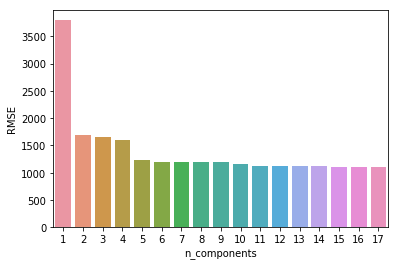

In [69]:
# PCR Regression - Cross-Validation with test MSE

results = pd.DataFrame()
predictors = college_dat.drop('Apps', axis=1).columns
c_range = range(1, len(predictors) + 1)
for train_idx, test_idx in model_selection.KFold(n_splits=10).split(college_dat):
    train, test = college_dat.iloc[train_idx], college_dat.iloc[test_idx]
    errors = []
    for c in c_range:
        pca = decomposition.PCA(n_components=c)
        X = pca.fit_transform(train.drop('Apps', axis=1))
        reg = linear_model.LinearRegression()
        reg.fit(X, train['Apps'])
        
        test_X = pca.transform(test.drop('Apps', axis=1))
        error = np.sqrt(metrics.mean_squared_error(test['Apps'], reg.predict(test_X)))
        errors.append(error)
    results = pd.concat([results, pd.DataFrame(errors, index=c_range).T], axis=0, ignore_index=True)

df = pd.DataFrame({'n_components' : c_range, 'RMSE' : results.mean()})
sns.barplot(x='n_components', y='RMSE', data=df)

In [70]:
test_error_pcr = df.sort_values('RMSE', ascending=True).iloc[0]['RMSE']
print('RMSE: {}'.format(test_error_pcr))

RMSE: 1098.9615610719898


(f) Fit a PLS model on the training set, with M chosen by cross-validation. Report the test error obtained, along with the value of M selected by cross-validation.

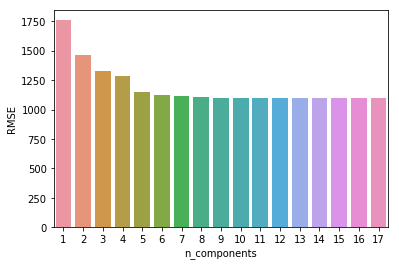

In [71]:
# PLS Regression - Cross-Validation with test MSE

results = pd.DataFrame()
predictors = college_dat.drop('Apps', axis=1).columns
c_range = range(1, len(predictors) + 1)
for train_idx, test_idx in model_selection.KFold(n_splits=10).split(college_dat):
    train, test = college_dat.iloc[train_idx], college_dat.iloc[test_idx]
    errors = []
    for c in c_range:
        reg = cross_decomposition.PLSRegression(n_components=c)
        reg.fit(train.drop('Apps', axis=1), train['Apps'])
        error = np.sqrt(metrics.mean_squared_error(test['Apps'], reg.predict(test.drop('Apps', axis=1))))
        errors.append(error)
    results = pd.concat([results, pd.DataFrame(errors, index=c_range).T], axis=0, ignore_index=True)

df = pd.DataFrame({'n_components' : c_range, 'RMSE' : results.mean()})
sns.barplot(x='n_components', y='RMSE', data=df)

In [72]:
test_error_pls = df.sort_values('RMSE', ascending=True).iloc[0]['RMSE']
print('RMSE: {}'.format(test_error_pls))

RMSE: 1098.9586217927474


(g) Comment on the results obtained. How accurately can we predict the number of college applications received? Is there much difference among the test errors resulting from these five approaches?

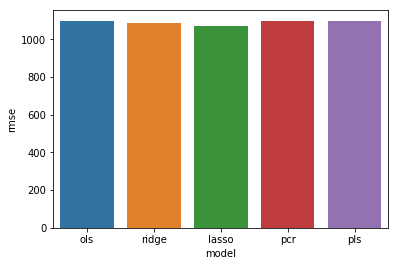

In [73]:
summary = pd.DataFrame({'rmse' : [test_error_ols, test_error_ridge, test_error_lasso, test_error_pcr, test_error_pls], \
                        'model': ['ols', 'ridge', 'lasso', 'pcr', 'pls']})

sns.barplot(x='model', y= 'rmse', data=summary)

In [75]:
summary.sort_values('rmse', ascending=True)

,rmse,model
2,1070.514298,lasso
1,1085.920717,ridge
0,1097.813600,ols
4,1098.958622,pls
3,1098.961561,pcr


In [80]:
college_dat['Apps'].mean()

3001.6383526383524

10. We have seen that as the number of features used in a model increases, the training error will necessarily decrease, but the test error may not. We will now explore this in a simulated data set.


(a) Generate a data set with p = 20 features, n = 1,000 observations, and an associated quantitative response vector generated according to the model
Y =Xβ+ε,
where β has some elements that are exactly equal to zero.

In [302]:
n = 100
p = 20
x = np.random.uniform(0,10,(n, p))
eps = np.random.normal(0, 1, n)
beta = np.random.normal(0, 1, p)
beta[0] = 0
beta[1] = 0
beta[2] = 0
beta[3] = 0
beta[4] = 0
beta[5] = 0
beta[6] = 0
beta[7] = 0
beta[8] = beta[9] ** 2
beta[10] = beta[11] ** 2

y = (x @ beta.reshape(-1, 1)) + eps.reshape(-1, 1)
data = pd.DataFrame(x, columns= ['x' + str(i) for i in range(0, x.shape[1])])
data['y'] = y
data.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x11,x12,x13,x14,x15,x16,x17,x18,x19,y
0,3.783240,2.822764,2.104245,0.085151,8.070863,9.613367,3.890487,7.576291,5.795171,3.736745,...,9.745869,1.079770,3.823860,5.726278,0.746411,3.317932,3.490703,2.305381,0.182134,14.017323
1,3.872013,1.235886,5.053738,0.075068,3.522952,8.167472,5.532001,5.415793,8.896883,1.439292,...,8.012286,1.586732,4.754267,7.819763,3.792867,0.562013,9.079879,0.633988,0.269867,19.181412
2,2.868493,4.097188,5.897901,2.579025,0.174440,2.931412,9.650473,6.266575,1.599330,4.434026,...,0.434932,7.079660,4.791268,6.003995,5.510795,8.790729,7.049488,2.820926,9.893762,10.489754
3,4.747117,9.260321,7.629206,9.956572,4.509392,8.280505,9.809595,7.245737,2.299474,6.779702,...,7.811970,1.374622,0.747643,6.002939,0.019969,3.797922,4.139976,1.060459,2.778484,9.574987
4,2.116980,4.778625,0.165573,5.720200,3.273290,9.592775,8.044132,8.663585,9.080542,1.654905,...,9.807599,6.937180,5.899757,9.969896,2.606421,5.331222,3.010509,1.172996,8.545720,26.689338


(b) Split your dataset into a training set containing 100 observations and a test set containing 900 observations.

In [303]:
train, test = model_selection.train_test_split(data, test_size=0.9)

(c) Perform best subset selection on the training set, and plot the training set MSE associated with the best model of each size.

0.0006680865036813836

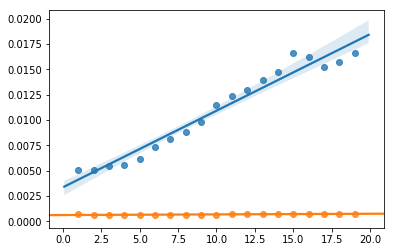

In [304]:
# Best subsets with smf is SLOW.

# Investigating performance of best subsets with sklearn

i = 1

smf_times = []
while i < data.shape[1] - 1 :
    cols = ['x' + str(j) for j in range(1, i + 1)]
    f = 'y ~ ' + ' + '.join(cols)
    tick = time.time()
    smf.ols(formula=f, data=data).fit()
    tock = time.time()
    smf_times.append(tock - tick)
    i += 1
    
sns.regplot(x=[x for x in range(1, data.shape[1] - 1)], y=smf_times)

i = 1
sk_times = []
while i < data.shape[1] - 1 :
    cols = ['x' + str(j) for j in range(1, i + 1)]
    x = data[cols]
    tick = time.time()
    model = linear_model.LinearRegression().fit(x, data['y'])
    model.score(x, data['y'])
    tock = time.time()
    sk_times.append(tock - tick)
    i += 1
    
sns.regplot(x=[x for x in range(1, data.shape[1] - 1)], y=sk_times)

# SKlearn kills statsmodels.
np.array(sk_times).mean()

In [420]:
def n_choose_k(n, k):
    return int(np.math.factorial(n) / (np.math.factorial(n - k) * np.math.factorial(k)))

def n_choose_upto_k_sum(n, up_to_k):
    return np.array([n_choose_k(n, k) for k in range(1, up_to_k + 1)]).sum()
    
def best_subset(n_predictors, target_column, data):
    i = 1
    predictors = data.drop(target_column, axis=1).columns
    search_size = n_choose_upto_k_sum(len(predictors), n_predictors)
    single_fit_time = 0.0012
    print('searching over {} models'.format(search_size))
    print('estimated time: {} seconds'.format(single_fit_time * search_size))
    top_models = []
    top_combs = []
    loop_tick = time.time() 
    while i <= n_predictors:
        print('-----------')
        print('n choose: {}'.format(i))
        cmbs = list(combinations(predictors, i))
        print('{} combinations'.format(len(cmbs)))
        tick = time.time()
        top_model = None
        top_score = None
        top_comb = None
        for s in cmbs:
            x = data[list(s)]
            model = linear_model.LinearRegression().fit(x, data[target_column])
            score = model.score(x, data[target_column])
            if top_score == None or score < top_score:
                top_model = model
                top_score = score
                top_comb = s
        tock = time.time()
        print('done: {} seconds ({} secs/model)'.format(tock - tick, (tock - tick) / len(cmbs)))
        top_models.append(top_model)
        top_combs.append(top_comb)
        tock = time.time()
        i += 1
    
    print('--- FINISHED ---')
    loop_tock = time.time()
    print('total time: {} seconds'.format((loop_tock-loop_tick)))
    print('secs/model: {}'.format((loop_tock-loop_tick)/ search_size))
    return pd.DataFrame({'model' : top_models, 'n_predictors' : range(1, n_predictors + 1)}), top_combs

In [306]:
df, combs = best_subset(4, 'y', train)

searching over 6195 models
estimated time: 7.433999999999999 seconds
-----------
n choose: 1
20 combinations
done: 0.025238990783691406 seconds (0.0012619495391845703 secs/model)
-----------
n choose: 2
190 combinations
done: 0.22151517868041992 seconds (0.0011658693614758943 secs/model)
-----------
n choose: 3
1140 combinations
done: 1.356029987335205 seconds (0.0011894999888905308 secs/model)
-----------
n choose: 4
4845 combinations
done: 5.599212884902954 seconds (0.001155668294097617 secs/model)
--- FINISHED ---
total time: 7.204585075378418 seconds
secs/model: 0.0011629677280675411


In [307]:
rmses = []
for idx, m in enumerate(df['model']):
    comb = combs[idx]
    x = test[list(comb)]
    preds = m.predict(x)
    rmses.append(np.sqrt(metrics.mean_squared_error(test['y'], preds)))
    
df = pd.DataFrame({'test_rmse' : rmses, 'n_predictors' : np.arange(1, len(rmses) + 1)})

(d) Plot the test set MSE associated with the best model of each size.

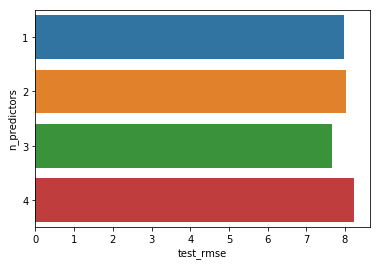

In [308]:
sns.barplot(y='n_predictors', x='test_rmse', data=df, orient='h')

(e) For which model size does the test set MSE take on its minimum value? Comment on your results. If it takes on its minimum value for a model containing only an intercept or a model containing all of the features, then play around with the way that you are generating the data in (a) until you come up with a scenario in which the test set MSE is minimized for an intermediate model size.

In [309]:
# Running best subsets for p=20 is going to take ~20 hours!!
# I'm going to do forward stepwise instead.

# Select between models with different numbers of predictors using adjusted training metrics
best = fwd_selection('y', train)
rmses = []
for m in best['model']:
    preds = m.predict(test)
    rmses.append(np.sqrt(metrics.mean_squared_error(test['y'], preds)))

df = pd.DataFrame({'model' : best['model'] ,'test_rmse' : rmses, 'n_predictors' : np.arange(1, len(rmses) + 1)})


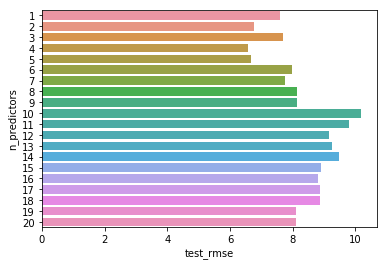

In [397]:
sns.barplot(y='n_predictors', x='test_rmse', data=df, orient='h')

(f) How does the model at which the test set MSE is minimized compare to the true model used to generate the data? Comment on the coefficient values.


In [311]:
best = df.sort_values('test_rmse', ascending=True).iloc[0]['model']
best.summary()

/usr/local/lib/python3.6/site-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.800
Method:                 Least Squares   F-statistic:                     9.993
Date:                Mon, 01 Oct 2018   Prob (F-statistic):             0.0133
Time:                        19:14:07   Log-Likelihood:                -19.122
No. Observations:                  10   AIC:                             48.24
Df Residuals:                       5   BIC:                             49.76
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -7.5641      3.561     -2.124      0.087     -16.717       1.589
x10            0.6322      0.298      2.121      0.087      -0.134       1.398
x11            1.3608      0.387      3.513      0.017       0.365       2.357
x13            0.6353      0.307      2.072      0.093      -0.153       1.423
x16            0.6766      0.384      1.761      0.139      -0.311       1.664
==============================================================================
Omnibus:                        1.865   Durbin-Watson:                   1.442
Prob(Omnibus):                  0.394   Jarque-Bera (JB):                1.269
Skew:                          -0.768   Prob(JB):                        0.530
Kurtosis:                       2.173   Cond. No.                         58.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

(g) Create a plot displaying: `sqrt(sum ((bj - bjr) ^ 2))` for a range of values
of r, where βˆjr is the jth coefficient estimate for the best model containing r coefficients. Comment on what you observe. How does this compare to the test MSE plot from (d)?

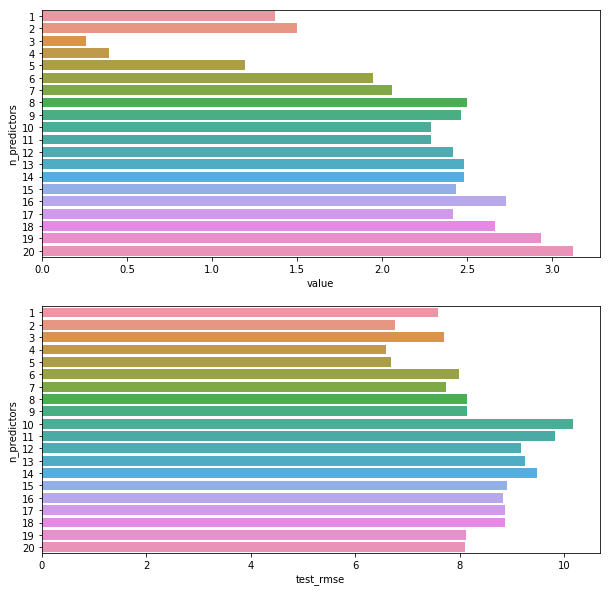

In [401]:
beta_lookup = pd.Series(beta, index=['x' + str(i) for i in range(0, len(beta))])
vs = []

i = 0
while i < df.shape[0]:
    row = sorted_df.iloc[i]
    coeffs = row['model'].params.drop('Intercept')
    betas = beta_lookup[coeffs.index]
    v = beta_lookup[list(coeffs.index)] - coeffs
    vs.append(np.sqrt((v ** 2).sum()))
    i += 1

xy = pd.DataFrame({'value': vs, 'n_predictors' : np.arange(1, i + 1)})

_, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10,10))
sns.barplot(y='n_predictors', x='value', data=xy, orient='h', ax=ax1)
sns.barplot(y='n_predictors', x='test_rmse', data=df, orient='h', ax=ax2)

11. We will now try to predict per capita crime rate in the Boston data set.

(a) Try out some of the regression methods explored in this chapter, such as best subset selection, the lasso, ridge regression, and PCR. Present and discuss results for the approaches that you consider.

(b) Propose a model (or set of models) that seem to perform well on this data set, and justify your answer. Make sure that you are evaluating model performance using validation set error, cross- validation, or some other reasonable alternative, as opposed to using training error.

(c) Does your chosen model involve all of the features in the data set? Why or why not?

In [414]:
boston_data = datasets.load_boston()
df_boston = pd.DataFrame(boston_data.data,columns=boston_data.feature_names)
df_boston['MEDV'] = pd.Series(boston_data.target)
df_boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [427]:
# Select between models with different numbers of predictors using cross validation
results = pd.DataFrame()
for train_idx, test_idx in model_selection.KFold(n_splits=5).split(df_boston):
    train = df_boston.iloc[train_idx]
    test = df_boston.iloc[test_idx]
    df, combs = best_subset(13, 'CRIM', train)
    rmses = []
    for idx, m in enumerate(df['model']):
        comb = combs[idx]
        x = test[list(comb)]
        preds = m.predict(x)
        rmses.append(np.sqrt(metrics.mean_squared_error(test['CRIM'], preds)))
    rmse = pd.DataFrame({'test_rmse' : rmses})
    results = results.append(rmse.T, ignore_index=True)
    
results


searching over 8191 models
estimated time: 9.829199999999998 seconds
-----------
n choose: 1
13 combinations
done: 0.017893075942993164 seconds (0.0013763904571533203 secs/model)
-----------
n choose: 2
78 combinations
done: 0.08938980102539062 seconds (0.0011460230900691105 secs/model)
-----------
n choose: 3
286 combinations
done: 0.3350977897644043 seconds (0.0011716705935818333 secs/model)
-----------
n choose: 4
715 combinations
done: 0.874377965927124 seconds (0.0012229062460519216 secs/model)
-----------
n choose: 5
1287 combinations
done: 1.4666271209716797 seconds (0.0011395704125654077 secs/model)
-----------
n choose: 6
1716 combinations
done: 1.9497790336608887 seconds (0.001136234868100751 secs/model)
-----------
n choose: 7
1716 combinations
done: 1.9710617065429688 seconds (0.0011486373581252732 secs/model)
-----------
n choose: 8
1287 combinations
done: 1.492173194885254 seconds (0.0011594197318455742 secs/model)
-----------
n choose: 9
715 combinations
done: 0.83200979

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,4.411323,4.755900,4.784093,5.129547,2.046046,2.147097,1.916061,2.925837,3.284684,3.023006,2.982842,2.266282,2.028975
1,3.782029,4.368218,4.670622,4.736891,4.789007,4.404211,5.677229,5.227295,7.070136,6.761502,6.654373,3.910064,3.350659
2,4.128744,3.383647,3.193658,3.447774,2.880217,2.803286,2.962172,2.837483,2.051755,1.982576,2.524979,2.174489,2.267941
3,12.421952,12.135320,11.946773,11.663072,11.055813,10.782303,10.723177,10.263207,10.244673,10.011402,11.265268,10.567198,10.058744
4,14.559303,13.630074,13.646259,13.835853,13.060408,12.657820,12.651616,14.276134,13.376914,12.917513,12.566299,11.688774,11.411557


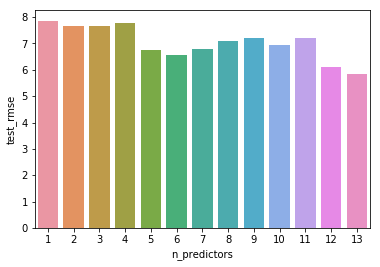

In [433]:
xy = pd.DataFrame({'test_rmse' : results.mean(), 'n_predictors' : results.columns + 1})
sns.barplot(x='n_predictors', y='test_rmse', data = xy)

In [435]:
# rmse for ols with all predictors (best performing subset)
xy.sort_values('test_rmse', ascending=True)['test_rmse'].iloc[0]

5.823575152341391

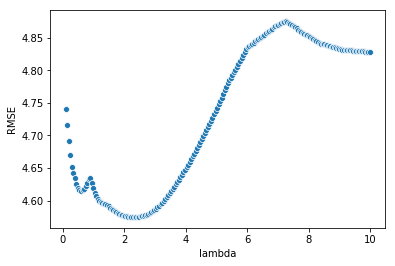

In [455]:
# LASSO Regression - Cross-Validation with test MSE

results = pd.DataFrame()
alpha_range = np.linspace(0.1, 10, num=200)
for train_idx, test_idx in model_selection.KFold(n_splits=12).split(df_boston):
    train, test = df_boston.iloc[train_idx], df_boston.iloc[test_idx]
    errors = []
    for alpha in alpha_range:
        reg = linear_model.Lasso(alpha=alpha, max_iter=1000000)
        reg.fit(train.drop('CRIM', axis=1), train['CRIM'])
        error = np.sqrt(metrics.mean_squared_error(test['CRIM'], reg.predict(test.drop('CRIM', axis=1))))
        errors.append(error)
    results = pd.concat([results, pd.DataFrame(errors, index=alpha_range).T], axis=0, ignore_index=True)
    

df = pd.DataFrame({'lambda' : alpha_range, 'RMSE' : results.mean()})
sns.scatterplot(x='lambda', y='RMSE', data=df)

In [456]:
lmbda, RMSE = df.sort_values('RMSE', ascending=True).iloc[0]
# best rmse for lasoo
RMSE

4.575267023519401

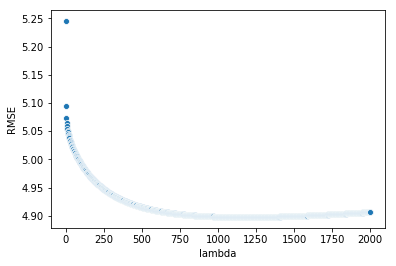

In [457]:
# RIDGE Regression - Cross-Validation with test MSE

results = pd.DataFrame()
alpha_range = np.linspace(10**-3, 2000, num=1000)
for train_idx, test_idx in model_selection.KFold(n_splits=8).split(df_boston):
    train, test = df_boston.iloc[train_idx], df_boston.iloc[test_idx]
    errors = []
    for alpha in alpha_range:
        reg = linear_model.Ridge(alpha=alpha)
        reg.fit(train.drop('CRIM', axis=1), train['CRIM'])
        error = np.sqrt(metrics.mean_squared_error(test['CRIM'], reg.predict(test.drop('CRIM', axis=1))))
        errors.append(error)
    results = pd.concat([results, pd.DataFrame(errors, index=alpha_range).T], axis=0, ignore_index=True)

df = pd.DataFrame({'lambda' : alpha_range, 'RMSE' : results.mean()})
sns.scatterplot(x='lambda', y='RMSE', data=df)

In [458]:
lmbda, RMSE = df.sort_values('RMSE', ascending=True).iloc[0]
# best rmse for ridge
RMSE

4.897662699449212

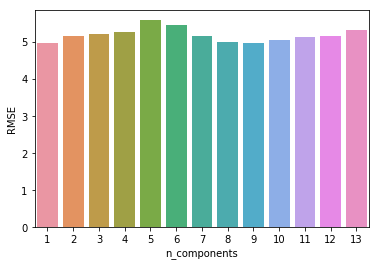

In [460]:
# PCR Regression - Cross-Validation with test MSE

results = pd.DataFrame()
predictors = df_boston.drop('CRIM', axis=1).columns
c_range = range(1, len(predictors) + 1)
for train_idx, test_idx in model_selection.KFold(n_splits=10).split(df_boston):
    train, test = df_boston.iloc[train_idx], df_boston.iloc[test_idx]
    errors = []
    for c in c_range:
        pca = decomposition.PCA(n_components=c)
        X = pca.fit_transform(train.drop('CRIM', axis=1))
        reg = linear_model.LinearRegression()
        reg.fit(X, train['CRIM'])
        
        test_X = pca.transform(test.drop('CRIM', axis=1))
        error = np.sqrt(metrics.mean_squared_error(test['CRIM'], reg.predict(test_X)))
        errors.append(error)
    results = pd.concat([results, pd.DataFrame(errors, index=c_range).T], axis=0, ignore_index=True)

df = pd.DataFrame({'n_components' : c_range, 'RMSE' : results.mean()})
sns.barplot(x='n_components', y='RMSE', data=df)